In [9]:
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import seaborn as sns
import timeit
import os
import re
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from scipy import interp
from sklearn import metrics, cross_validation, grid_search
from scipy.optimize import minimize, fmin
from scipy import integrate

#confusion_matrix, roc_curve, auc, f1_score
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
sns.set(style="whitegrid", color_codes=True, context="poster")

mainpath = '/Users/jorgetil/Astro/HITS'

In [10]:
def PR_ROC_curves(sample, y_score, classes):
    import matplotlib.cm as cm
    # matrix with labels, shape (n_obj,n_class)
    y_test = np.zeros(y_score.shape, dtype = int)
    classes = np.asarray(classes)
    #print y_test
    #print classes
    for k in range(len(y_test)):
        mask = sample[k] == classes
        y_test[k,mask] = 1
    #print y_test
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = metrics.roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])
        precision[i], recall[i], _ = metrics.precision_recall_curve(y_test[:, i],
                                                        y_score[:, i])
        average_precision[i] = metrics.average_precision_score(y_test[:, i],
                                                               y_score[:, i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = metrics.roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])
    
    # Compute micro-average P-R curve and ROC area
    precision["micro"], recall["micro"], _ = metrics.precision_recall_curve(y_test.ravel(),
                                                                    y_score.ravel())
    average_precision["micro"] = metrics.average_precision_score(y_test, y_score,
                                                     average="micro")

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(classes))]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(classes)):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= float(len(classes))

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])
    
    # Plot all P-R and ROC curves
    fig, ax = plt.subplots(ncols=2,figsize = (15,6))
    ax[0].plot(fpr["micro"], tpr["micro"], label='micro-average ROC curve (area = %.4f)' 
             % (roc_auc["micro"]), linewidth=4, color='b')
    ax[1].plot(recall["micro"], precision["micro"],
         label='micro-average Precision-recall curve (area = %.2f)'
               % (average_precision["micro"]), linewidth=4, color='b')

    ax[0].plot(fpr["macro"], tpr["macro"], label='macro-average ROC curve (area = %.4f)'
             % (roc_auc["macro"]), linewidth=4, color='g')
    
    colors = cm.rainbow(np.linspace(0, 1, len(classes)))
    for i in range(len(classes)):
        ax[0].plot(fpr[i], tpr[i], label='ROC curve of class %s (area = %.4f)'
                    % (classes[i], roc_auc[i]), linewidth=2, color=colors[i])
        ax[1].plot(recall[i], precision[i], label='P-R curve of class %s (area = %.4f)'
                    % (classes[i], average_precision[i]), linewidth=2, color=colors[i])

    ax[0].plot([0, 1], [0, 1], 'k--')
    #plt.xlim([0.0, 0.4])
    #plt.ylim([0.6, 1.05])
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_ylabel('True Positive Rate')
    ax[0].set_title('ROC curves to multi-class')
    ax[0].legend(loc="lower right", fontsize='large')
    
    #plt.xlim([0.0, 0.4])
    #plt.ylim([0.6, 1.05])
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('Extended Precision-Recall curves to multi-class')
    ax[1].legend(loc="lower left", fontsize='large')
    
    plt.show()

In [11]:
def conf_matrix(true, predict, classes, normalized=True):
    cm = metrics.confusion_matrix(true, predict, labels=classes)
    if normalized:
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(cm_normalized, annot=True, fmt='0.3f', linewidths=.5, 
                    xticklabels=classes, yticklabels=classes, cmap="GnBu", 
                    annot_kws={'size': 'x-large'})
    else:
        sns.heatmap(cm, annot=True, fmt='f', linewidths=.5, 
                    xticklabels=clases, yticklabels=clases, cmap="GnBu", 
                    annot_kws={'size': 'x-large'})
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix for RF classifier')
    plt.show()

In [5]:
# load feature table into DF
table_file = '%s/tables/Blind15A_tables+feat_pl_var_type_spCL_spClass.csv'\
              %(mainpath)
table_15 = pd.read_csv(table_file)
table_15.set_index('ID', inplace=True)

/Users/jorgetil/miniconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (81,82,83,84,85) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [13]:
# load feature table into DF
table_file = '%s/tables/Blind15A_label_sample.csv'\
              %(mainpath)
label_sample = pd.read_csv(table_file)
label_sample.set_index('ID', inplace=True)
print 'Shape of labeled set: ', label_sample.shape

Shape of labeled set:  (2752, 86)


In [14]:
# columns with features
feat = table_15.columns.values
shape_feat = ['ELLIPTICITY','FLAGS','FLUX_RADIUS','FWHM','KRON_RADIUS']
var_feat = feat[17:78]
print table_15.shape
table_15 = table_15.dropna(subset=var_feat)
print table_15[var_feat].shape

(1472128, 86)
(1472128, 61)


In [15]:
print var_feat

['Amplitude' 'AndersonDarling' 'Autocor_length' 'Beyond1Std' 'CAR_mean'
 'CAR_sigma' 'CAR_tau' 'Color' 'Con' 'Eta_e' 'FluxPercentileRatioMid20'
 'FluxPercentileRatioMid35' 'FluxPercentileRatioMid50'
 'FluxPercentileRatioMid65' 'FluxPercentileRatioMid80'
 'Freq1_harmonics_amplitude_0' 'Freq1_harmonics_amplitude_1'
 'Freq1_harmonics_amplitude_2' 'Freq1_harmonics_amplitude_3'
 'Freq1_harmonics_rel_phase_0' 'Freq1_harmonics_rel_phase_1'
 'Freq1_harmonics_rel_phase_2' 'Freq1_harmonics_rel_phase_3'
 'Freq2_harmonics_amplitude_0' 'Freq2_harmonics_amplitude_1'
 'Freq2_harmonics_amplitude_2' 'Freq2_harmonics_amplitude_3'
 'Freq2_harmonics_rel_phase_0' 'Freq2_harmonics_rel_phase_1'
 'Freq2_harmonics_rel_phase_2' 'Freq2_harmonics_rel_phase_3'
 'Freq3_harmonics_amplitude_0' 'Freq3_harmonics_amplitude_1'
 'Freq3_harmonics_amplitude_2' 'Freq3_harmonics_amplitude_3'
 'Freq3_harmonics_rel_phase_0' 'Freq3_harmonics_rel_phase_1'
 'Freq3_harmonics_rel_phase_2' 'Freq3_harmonics_rel_phase_3' 'Gskew'
 'Line

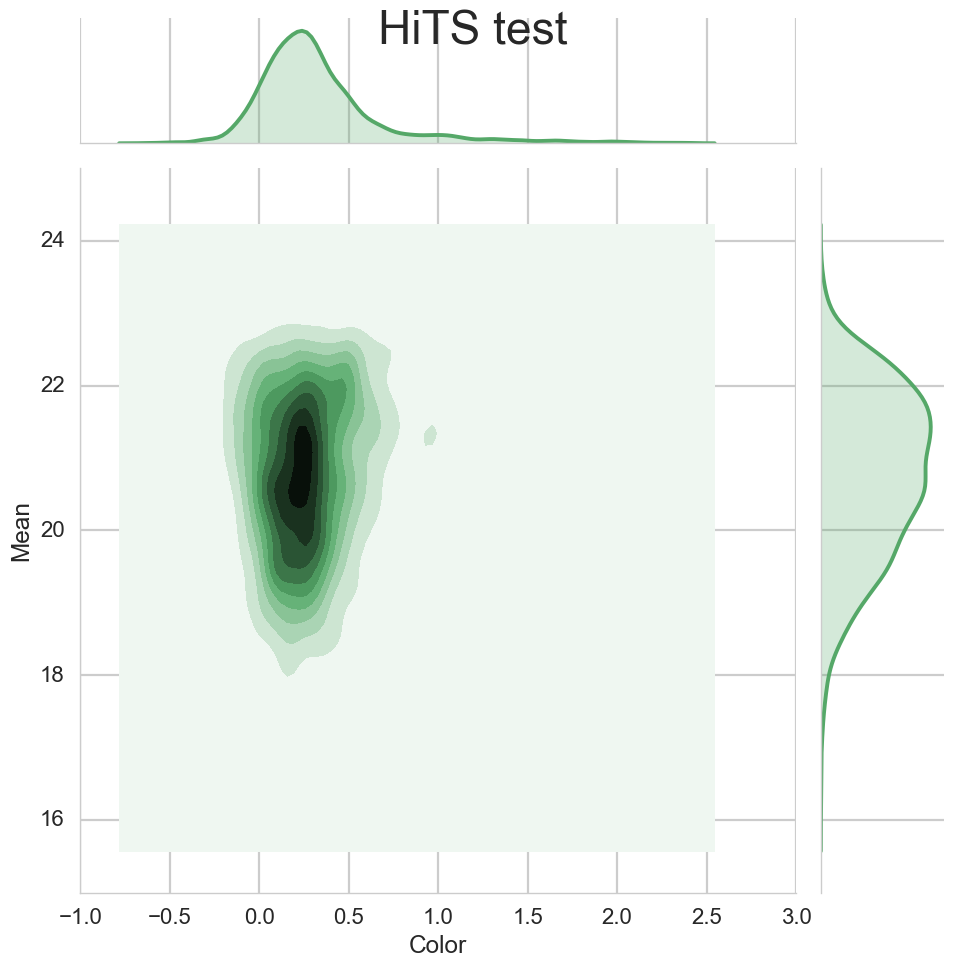

In [16]:
# CMD of detections
g = sns.jointplot(x="Color", y="Mean", data=label_sample.query('Var_Type == "QSO"'), kind="kde", 
                  stat_func=None, size=10, ratio=5, color='g')
g.fig.suptitle('HiTS test', size='xx-large')
plt.show()

In [10]:
# load feature table into DF
MACHO_file = '%s/MACHO/macho_training_set_feat.csv' %(mainpath)
MACHO = pd.read_csv(MACHO_file)
MACHO = MACHO.set_index('macho_id').dropna()
MACHO = MACHO[MACHO.label != 'LPV']
print MACHO.shape

(5698, 65)


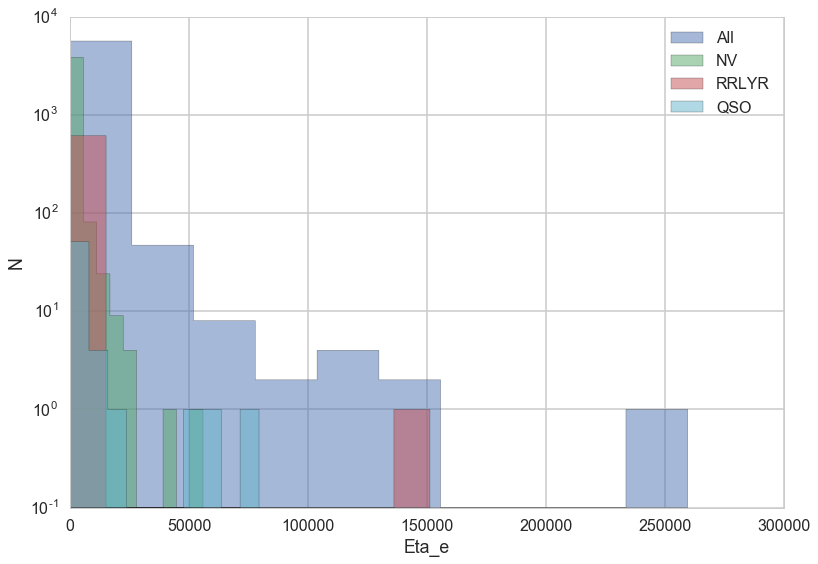

In [11]:
# distribution of Perdio from LS
plt.hist(MACHO['Eta_e'], color='b', log=True, 
         histtype = 'stepfilled', label='All', alpha=0.5)
plt.hist(MACHO.query('label=="NV"')['Eta_e'], color='g', log=True, 
         histtype = 'stepfilled', label='NV', alpha =0.5)
plt.hist(MACHO.query('label=="RRLYR"')['Eta_e'], color='r', log=True, 
         histtype = 'stepfilled', label='RRLYR', alpha =0.5)
plt.hist(MACHO.query('label=="QSO"')['Eta_e'], color='c', log=True, 
         histtype = 'stepfilled', label='QSO', alpha=0.5)
plt.legend(loc='best')
plt.xlabel('Eta_e')
plt.ylabel('N')
plt.show()

In [12]:
MACHO_feat = MACHO.columns.values[:-1]
MACHO_x_HiTS = MACHO.query('label == "QSO" or label == "EB" \
                            or label == "RRLYR" or label == "CEP" or label == "NV"')
HiTS_x_MACHO = label_sample.query('Var_Type == "QSO" or Var_Type == "EB" \
                            or Var_Type == "RRLYR" or Var_Type == "CEP" or Var_Type == "NV"')
#MACHO_x_HiTS = MACHO_x_HiTS.query('Period_fit < .25 and PeriodLS < 100')
print MACHO_x_HiTS.shape

(4991, 65)


In [13]:
# Crosscorrelate feature list
FEATURES = np.sort(list(set(MACHO_feat) & set(var_feat)))
FEATURES = np.delete(FEATURES, np.where(FEATURES =='Freq1_harmonics_rel_phase_0'))
FEATURES = np.delete(FEATURES, np.where(FEATURES =='Freq2_harmonics_rel_phase_0'))
FEATURES = np.delete(FEATURES, np.where(FEATURES =='Freq3_harmonics_rel_phase_0'))
FEATURES = np.delete(FEATURES, np.where(FEATURES =='Mean'))
print FEATURES
print FEATURES.shape

['Amplitude' 'AndersonDarling' 'Autocor_length' 'Beyond1Std' 'CAR_mean'
 'CAR_sigma' 'CAR_tau' 'Color' 'Con' 'Eta_e' 'FluxPercentileRatioMid20'
 'FluxPercentileRatioMid35' 'FluxPercentileRatioMid50'
 'FluxPercentileRatioMid65' 'FluxPercentileRatioMid80'
 'Freq1_harmonics_amplitude_0' 'Freq1_harmonics_amplitude_1'
 'Freq1_harmonics_amplitude_2' 'Freq1_harmonics_amplitude_3'
 'Freq1_harmonics_rel_phase_1' 'Freq1_harmonics_rel_phase_2'
 'Freq1_harmonics_rel_phase_3' 'Freq2_harmonics_amplitude_0'
 'Freq2_harmonics_amplitude_1' 'Freq2_harmonics_amplitude_2'
 'Freq2_harmonics_amplitude_3' 'Freq2_harmonics_rel_phase_1'
 'Freq2_harmonics_rel_phase_2' 'Freq2_harmonics_rel_phase_3'
 'Freq3_harmonics_amplitude_0' 'Freq3_harmonics_amplitude_1'
 'Freq3_harmonics_amplitude_2' 'Freq3_harmonics_amplitude_3'
 'Freq3_harmonics_rel_phase_1' 'Freq3_harmonics_rel_phase_2'
 'Freq3_harmonics_rel_phase_3' 'LinearTrend' 'MaxSlope' 'Meanvariance'
 'MedianAbsDev' 'MedianBRP' 'PairSlopeTrend' 'PercentAmplitude'
 

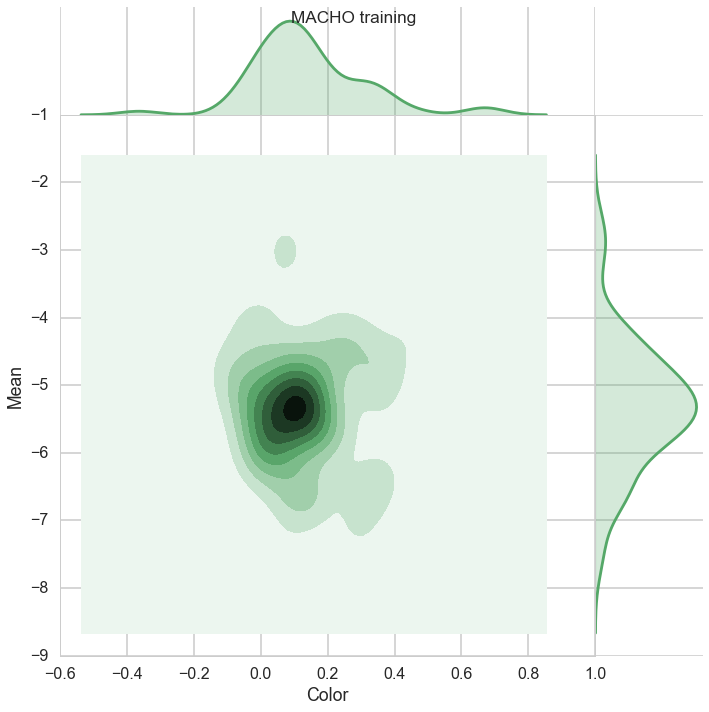

In [14]:
# CMD of detections
graph = sns.jointplot(x="Color", y="Mean", data=MACHO_x_HiTS.query('label == "QSO"'), kind="kde", 
                  stat_func=None, size=10, ratio=5, color='g', space =0)
graph.fig.suptitle('MACHO training', size='xx-large')
plt.show()

# Random Forest in HiTS

### Grid search for RFC parameters

Best params:
{'max_features': 'sqrt', 'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1}

# RFC in MACHO

In [15]:
M_train_sample, M_test_sample = cross_validation.train_test_split(MACHO,
                                                              test_size=0.4, random_state=15)
RFC = RandomForestClassifier(n_estimators=100, criterion='gini',
                           max_features='sqrt', max_depth=10, n_jobs=2,
                            min_samples_leaf=1, oob_score=True)

In [16]:
FEAT_RANK_M = []
for k in range(40):
    print '\r %i' % (k+1),
    RFC.fit(M_train_sample[FEATURES], M_train_sample['label'])
    
    M_score = RFC.score(M_test_sample[FEATURES], M_test_sample['label'])
    M_clases = RFC.classes_
    M_y_prob = RFC.predict_proba(M_test_sample[FEATURES])
    M_type_pred = RFC.predict(M_test_sample[FEATURES])
    M_test_sample['Var_Type_pred_M'] = M_type_pred

    #print 'Score in test set: \t%f' % (M_score)
    #print 'F1-score in test set: \t%f' % (metrics.f1_score(M_test_sample['label'],
    #                                M_type_pred, average='macro',labels=M_clases))
    
    FEAT_RANK_M.append(RFC.feature_importances_)
FEAT_RANK_M = np.mean(np.array(FEAT_RANK_M), axis=0)

 1

/Users/jorgetil/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


 40


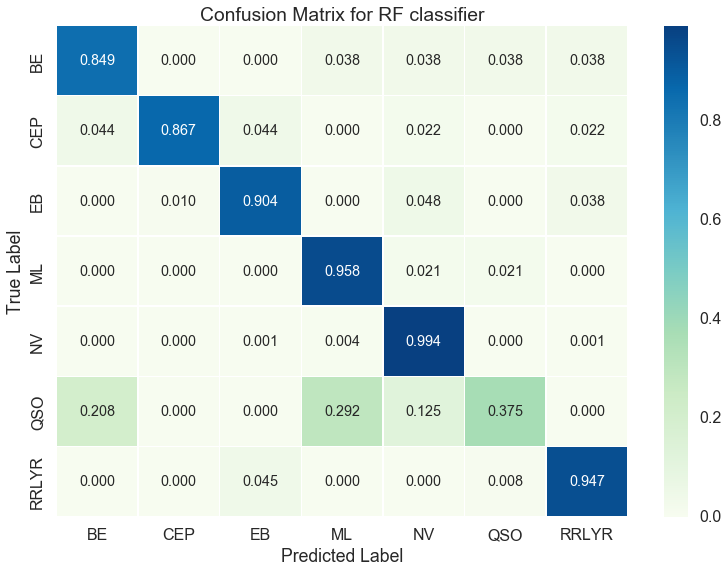

In [24]:
conf_matrix(M_test_sample['label'].values, M_test_sample['Var_Type_pred_M'].values, M_clases)

In [17]:
# feature importance for MACHO
sorted_FATS_feats_M = pd.DataFrame(np.array([FEATURES, FEAT_RANK_M]).T,
                    columns=['FEATURES','Score'])
sorted_FATS_feats_M.sort_values('Score', ascending=False, inplace=True)
sorted_FATS_feats_M

,FEATURES,Score
47,Psi_eta,0.10044354699
46,Psi_CS,0.0899254709197
7,Color,0.0854621352846
51,SlottedA_length,0.0704339835955
8,Con,0.0520096832412
12,FluxPercentileRatioMid50,0.0407664122322
49,Rcs,0.03973234581
13,FluxPercentileRatioMid65,0.0381107938621
44,PeriodLS,0.0350122201378
14,FluxPercentileRatioMid80,0.0342446758066


# Comparisson between MACHO and HiTS features distribution

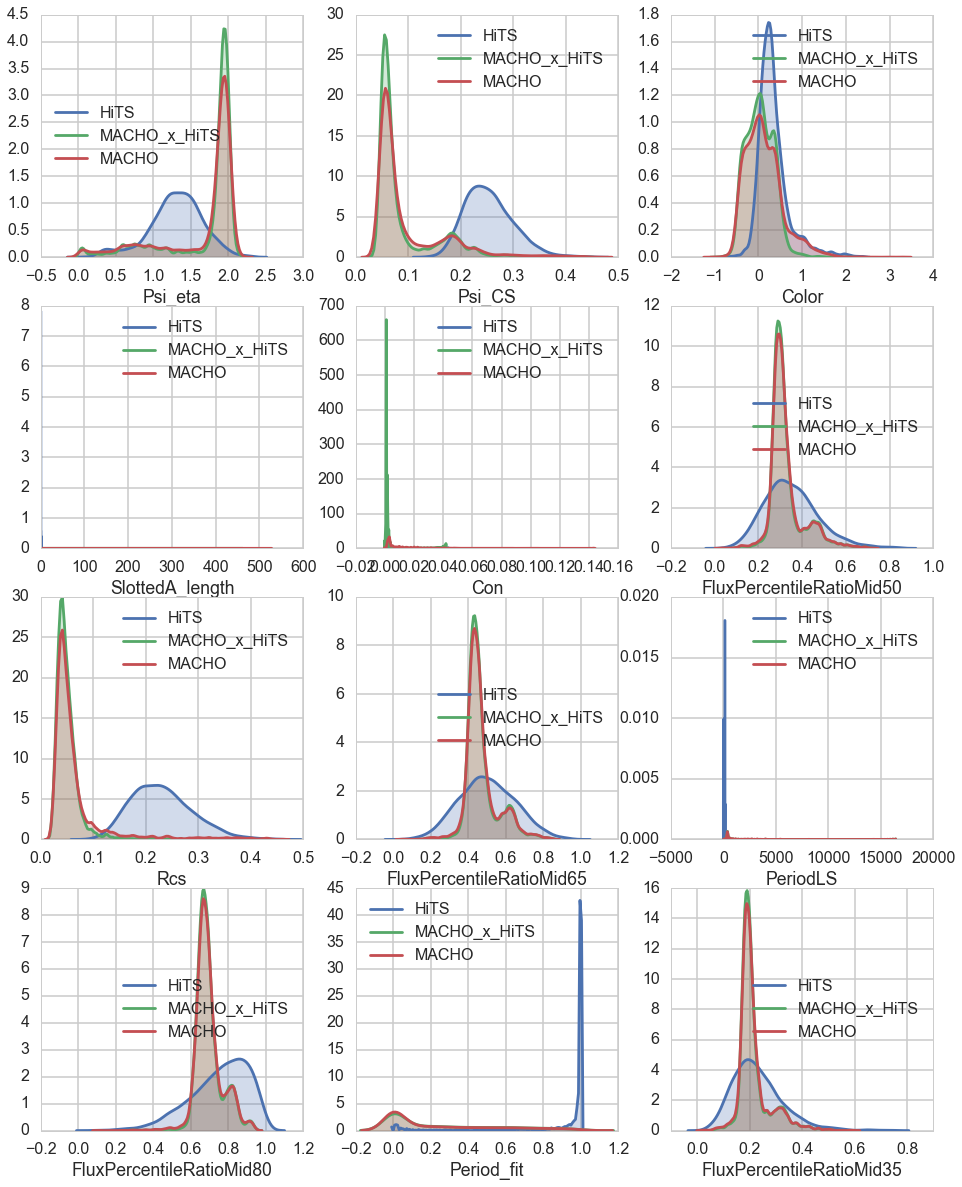

In [26]:
f, axis = plt.subplots(4,3, figsize=(16,20))
for feat,ax in zip(sorted_FATS_feats_M.FEATURES[:12], axis.ravel()):
    sns.kdeplot(label_sample[feat], shade=True, label='HiTS', ax=ax)
    sns.kdeplot(MACHO_x_HiTS[feat], shade=True, label='MACHO_x_HiTS', ax=ax)
    sns.kdeplot(MACHO[feat], shade=True, label='MACHO', ax=ax)
    ax.set_xlabel(feat)
plt.show()

# Transfer Learning from MACHO using feature distribution and only 4 classes present in HiTS

In [27]:
def transform_distribution(dist_1, dist_2, mode='scale'):
    dist_1_kde = gaussian_kde(dist_1)
    dist_2_kde = gaussian_kde(dist_2)
    if mode=='scale':
        # to apply the transformation:
        # dist_1' = (dist_1 / alpha)
        dist_1_max = fmin(lambda x: -dist_1_kde.evaluate(x), np.mean(dist_1), disp=False)
        dist_2_max = fmin(lambda x: -dist_2_kde.evaluate(x), np.mean(dist_2), disp=False)
        alpha = dist_1_max/dist_2_max
        return alpha
    
    elif mode=='translation+scale':
        # to apply the transformation:
        # dist_1' = (dist_1 * alpha) - x_0
        dist_1_max = fmin(lambda x: -dist_1_kde.evaluate(x), np.mean(dist_1), disp=False)[0]
        dist_2_max = fmin(lambda x: -dist_2_kde.evaluate(x), np.mean(dist_2), disp=False)[0]
        #print '1:',dist_1_max ,'2:', dist_2_max
        alpha = dist_1_kde(dist_1_max)[0]/dist_2_kde(dist_2_max)[0]
        dist_1_kde = gaussian_kde(dist_1*alpha)
        dist_2_kde = gaussian_kde(dist_2)
        dist_1_max = fmin(lambda x: -dist_1_kde.evaluate(x), np.mean(dist_1*alpha), disp=False)[0]
        dist_2_max = fmin(lambda x: -dist_2_kde.evaluate(x), np.mean(dist_2), disp=False)[0]
        #print '1:',dist_1_max ,'2:', dist_2_max
        x_0 = dist_1_max - dist_2_max
        return [x_0, alpha]
    
    elif mode=='integral':
        dist_1_max = fmin(lambda x: -dist_1_kde.evaluate(x), np.mean(dist_1), disp=False)[0]
        dist_2_max = fmin(lambda x: -dist_2_kde.evaluate(x), np.mean(dist_2), disp=False)[0]
        x_0 = dist_1_max - dist_2_max
        alpha_0 = 1
        def integrand(x, alpha):
            return (alpha*dist_1_kde.evaluate(x - x_0) - dist_2_kde.evaluate(x))**2
        def function(cte_0):
            alpha_0 = cte_0[0]
            return integrate.quad(integrand, -np.inf, np.inf, args=alpha_0)[0]
        alpha = minimize(function, alpha_0, method='SLSQP').x[0]
        return [x_0, alpha]

Psi_eta
[3.0814723093486664, 2.2540477750273373]


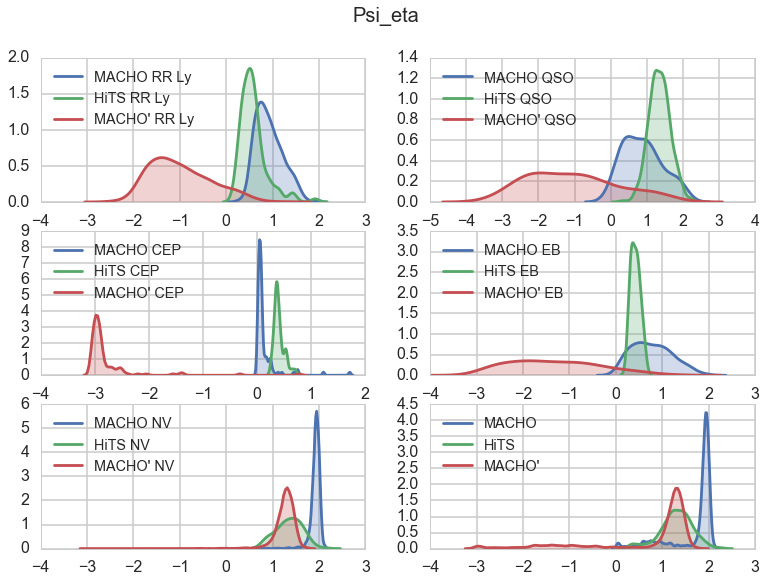

Psi_CS
[-0.10149989942082011, 2.334049764811728]


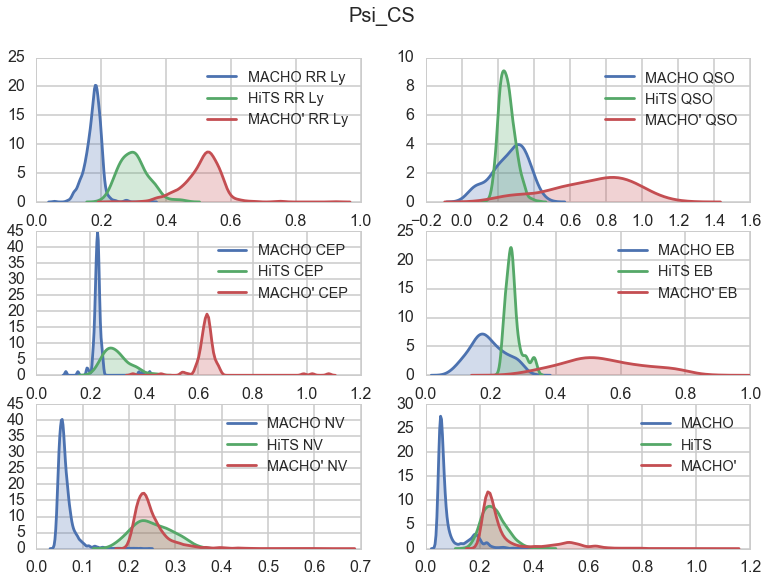

Color
[-0.20450783064284933, 0.72604821377395146]


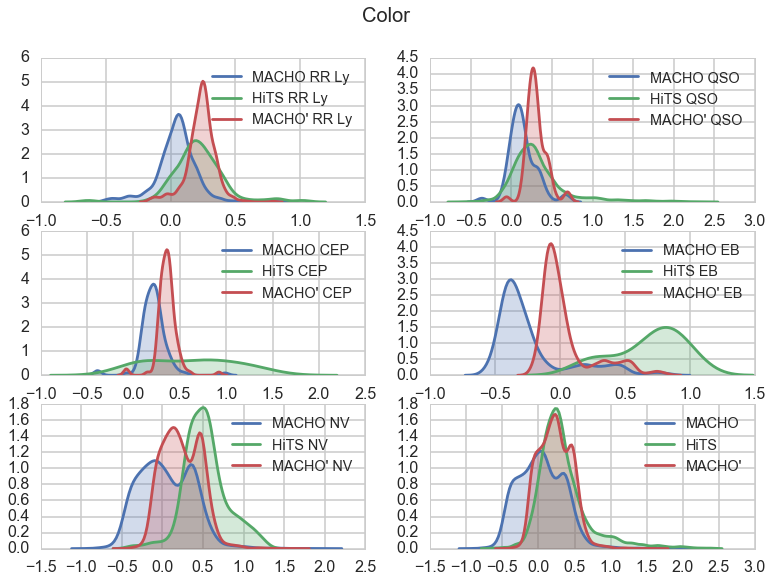

SlottedA_length
[-0.06574258551845695, 0.01014474723288452]


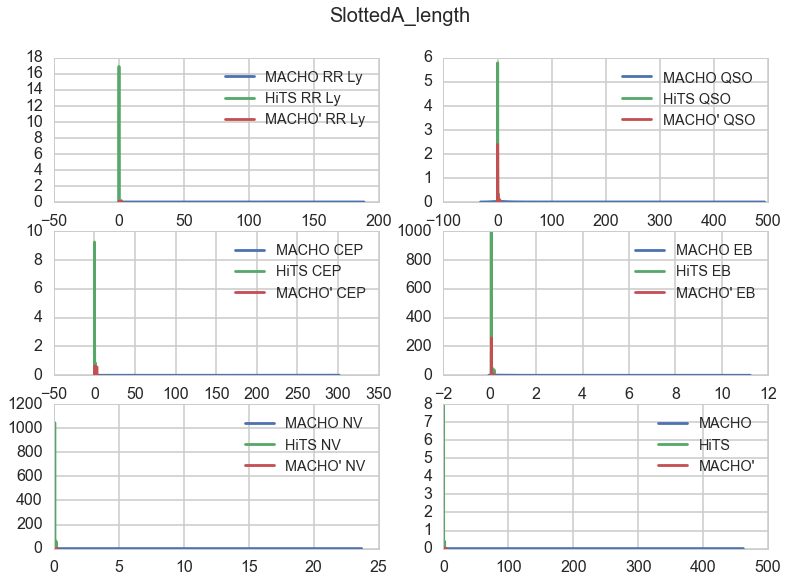

Con
[2.4687000070925121e-05, 1.055595945255857]


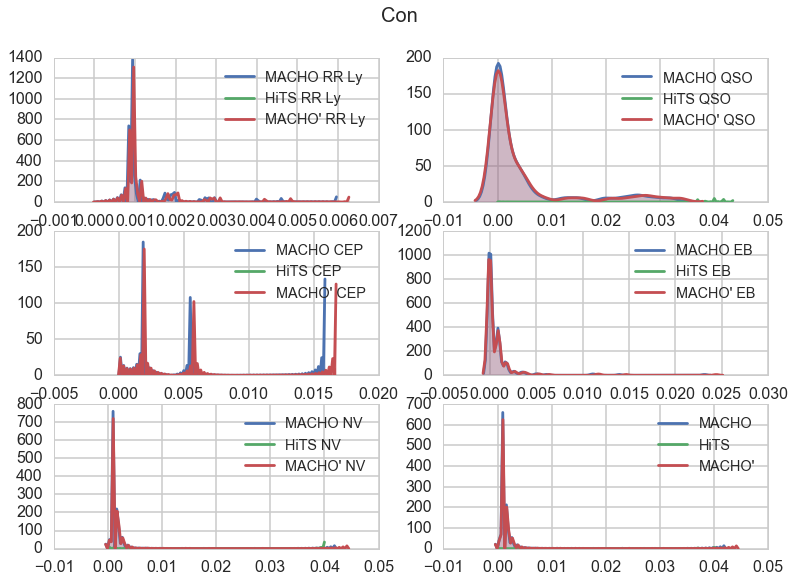

FluxPercentileRatioMid50
[0.60970486386459632, 3.1177374043463089]


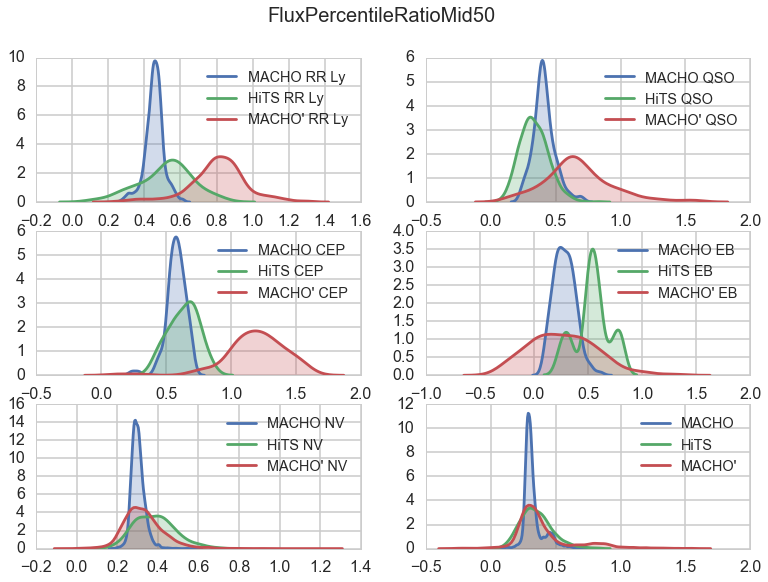

Rcs
[-0.059874034465483228, 3.9612861166962823]


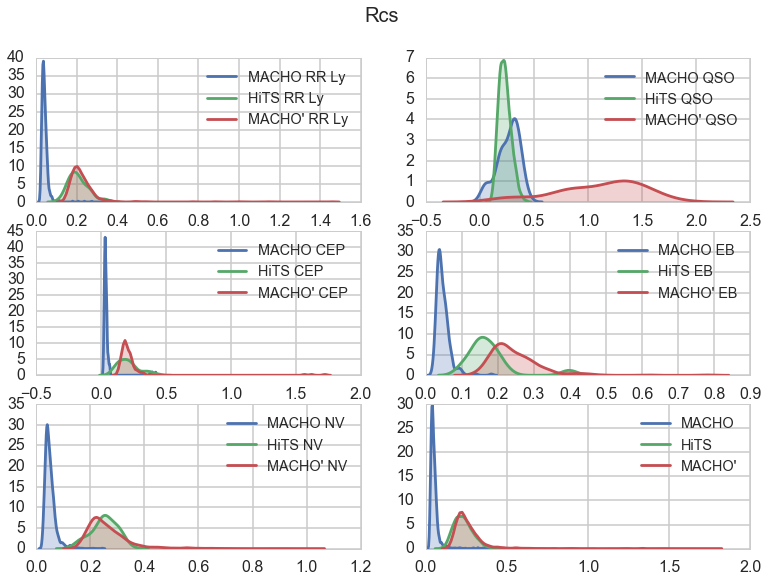

FluxPercentileRatioMid65
[0.98517258830740972, 3.3579171119568865]


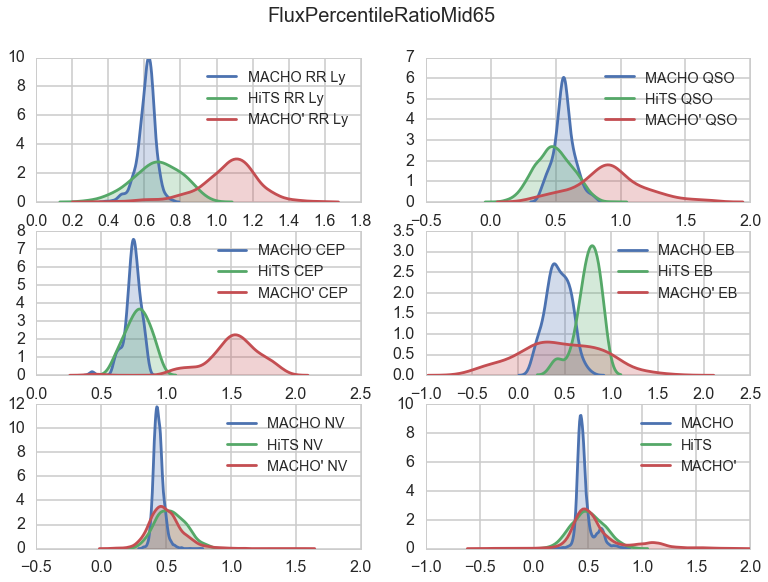

PeriodLS
[-0.074944459547151343, 0.02732937446469633]


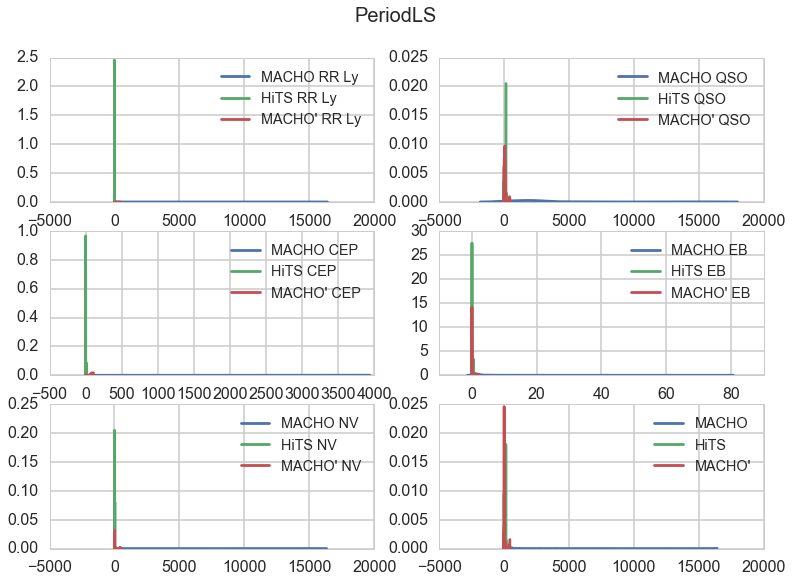

FluxPercentileRatioMid80
[1.3452108370426781, 3.2891326872564126]


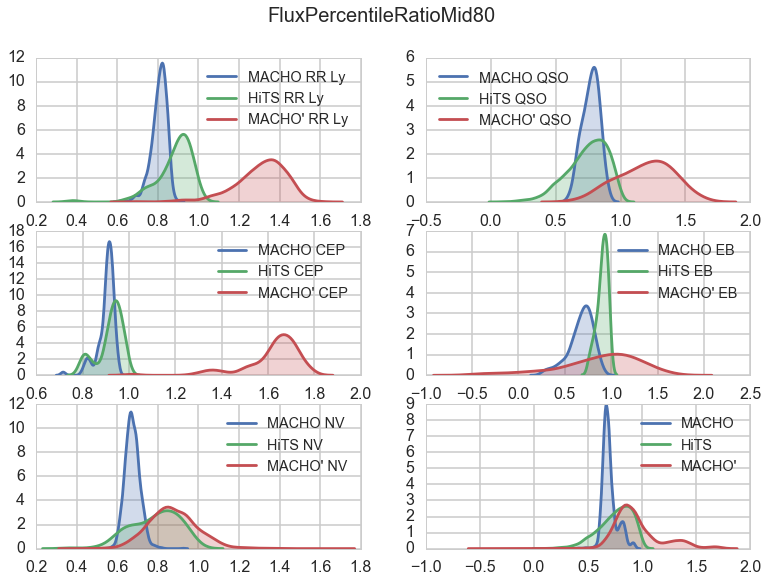

Period_fit
[-0.99005396767338671, 0.50598538670462734]


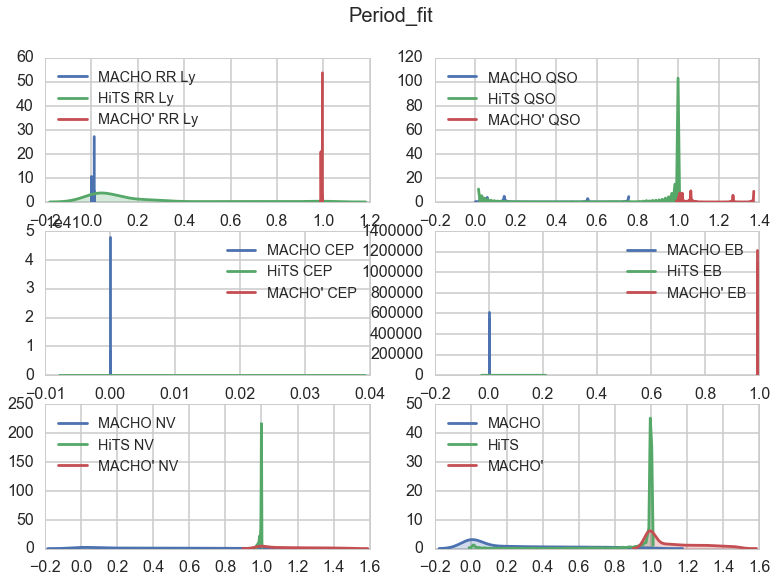

FluxPercentileRatioMid35
[0.40000093033778872, 3.112354262202218]


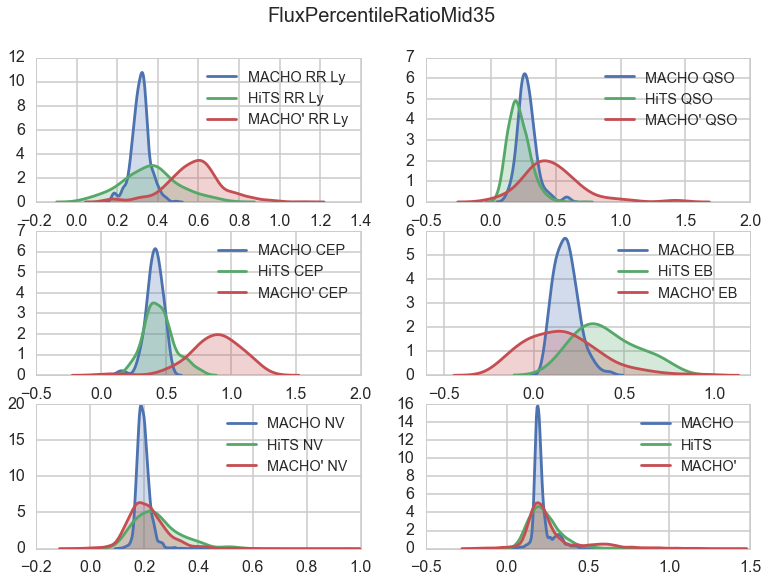

FluxPercentileRatioMid20
[0.24698146092188139, 3.3713331783395035]


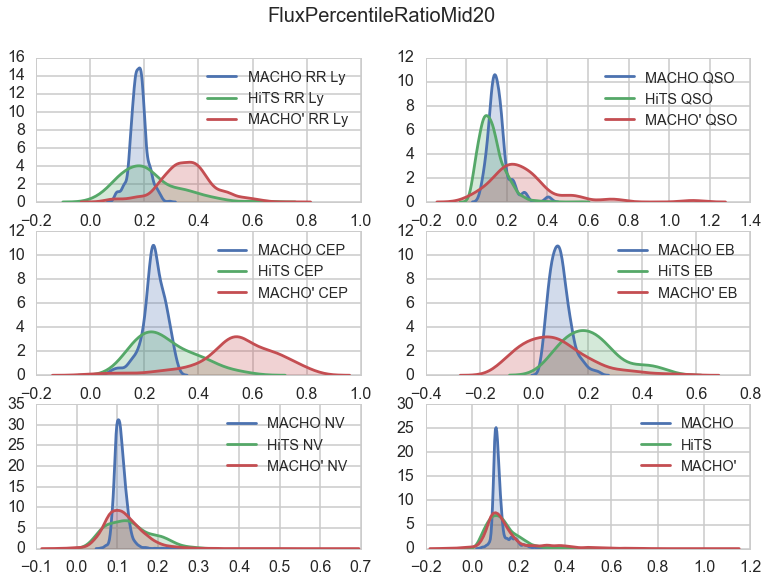

CAR_tau
[5817.6062218556917, 2.9768239293493406]


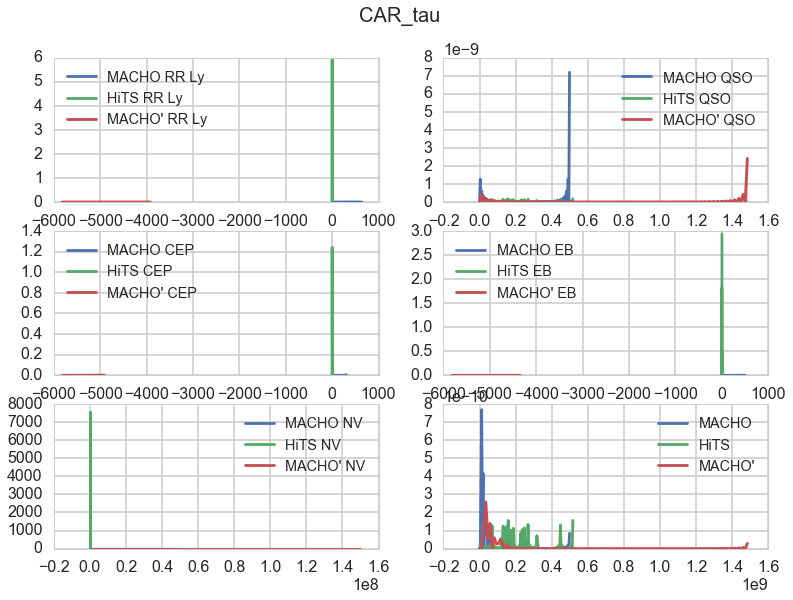

CAR_mean
[-76.319506887796848, 1.0660287907837949]


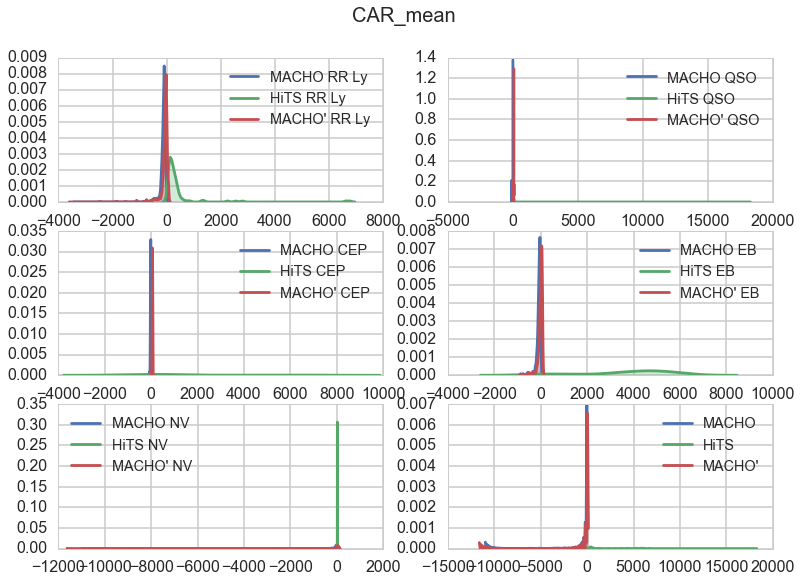

Eta_e
[-9.9685216475485987, 0.079442567578142539]
Skew
[-1.0045278025145321, 2.0731667145277988]
Beyond1Std
[0.20480351932341803, 2.1359592461880705]
SmallKurtosis
[2.0460524389051979, 0.65382436784928]
Autocor_length
[-0.91576841661047226, 0.083803004592134606]
PercentAmplitude
[-0.010564556814435386, 0.03109562168612548]
Freq1_harmonics_amplitude_0
[0.0046507554396827827, 1.006731361934498]
MedianBRP
[0.97775421294727249, 1.695063555685911]
Freq1_harmonics_amplitude_1
[0.0020804293156388466, 1.3718836652940773]
MaxSlope
[0.62977920071215188, 0.040398702448456461]
StetsonK
[0.083329234756530424, 1.1721130353013163]
Meanvariance
[-0.0028206900346431749, 0.054733232647191918]
PercentDifferenceFluxPercentile
[-0.0086598422828284109, 0.056921734692671977]
MedianAbsDev
[0.012859997941710567, 0.20809663949504262]
CAR_sigma
[-0.026976310163536941, 0.5352599957623132]
Amplitude
[0.017704048982137149, 0.24739246477897503]
Q31
[0.025918527994431138, 0.2165328801022624]
Std
[0.008293789144492993

In [29]:
# using global distribution
transf = dict()
MACHO_x_HiTS_t = MACHO_x_HiTS.copy()
MACHO_t = MACHO.copy()
for p,feat in enumerate(sorted_FATS_feats_M.FEATURES):
    trans_aux = []
    print feat
    M_ = MACHO_x_HiTS[feat].values
    H_ = HiTS_x_MACHO[feat].values

    transf[feat] = transform_distribution(M_, H_, mode='translation+scale')
    print transf[feat]
    
    MACHO_x_HiTS_t[feat] = (MACHO_x_HiTS_t[feat] * transf[feat][1]) - transf[feat][0]
    MACHO_t[feat] = (MACHO_t[feat] * transf[feat][1]) - transf[feat][0]
    
    if p < 15:
        f, ax = plt.subplots(3,2)
        f.suptitle(feat, fontsize=20)
        try:
            sns.kdeplot(MACHO_x_HiTS.query('label=="RRLYR"')[feat], shade=True, ax=ax[0,0], label="MACHO RR Ly")
            sns.kdeplot(HiTS_x_MACHO.query('Var_Type=="RRLYR"')[feat], shade=True, ax=ax[0,0], label="HiTS RR Ly")
            sns.kdeplot(MACHO_x_HiTS_t.query('label=="RRLYR"')[feat], shade=True, ax=ax[0,0], label="MACHO' RR Ly")
            ax[0,0].legend(loc='best', fontsize='x-large')

            sns.kdeplot(MACHO_x_HiTS.query('label=="QSO"')[feat], shade=True, ax=ax[0,1], label="MACHO QSO")
            sns.kdeplot(HiTS_x_MACHO.query('Var_Type=="QSO"')[feat], shade=True, ax=ax[0,1], label="HiTS QSO")
            sns.kdeplot(MACHO_x_HiTS_t.query('label=="QSO"')[feat], shade=True, ax=ax[0,1], label="MACHO' QSO")
            ax[0,1].legend(loc='best', fontsize='x-large')

            sns.kdeplot(MACHO_x_HiTS.query('label=="CEP"')[feat], shade=True, ax=ax[1,0], label="MACHO CEP")
            sns.kdeplot(HiTS_x_MACHO.query('Var_Type=="CEP"')[feat], shade=True, ax=ax[1,0], label="HiTS CEP")
            sns.kdeplot(MACHO_x_HiTS_t.query('label=="CEP"')[feat], shade=True, ax=ax[1,0], label="MACHO' CEP")
            ax[1,0].legend(loc='best', fontsize='x-large')

            sns.kdeplot(MACHO_x_HiTS.query('label=="EB"')[feat], shade=True, ax=ax[1,1], label="MACHO EB")
            sns.kdeplot(HiTS_x_MACHO.query('Var_Type=="EB"')[feat], shade=True, ax=ax[1,1], label="HiTS EB")
            sns.kdeplot(MACHO_x_HiTS_t.query('label=="EB"')[feat], shade=True, ax=ax[1,1], label="MACHO' EB")
            ax[1,1].legend(loc='best', fontsize='x-large')
            
            sns.kdeplot(MACHO_x_HiTS.query('label=="NV"')[feat], shade=True, ax=ax[2,0], label="MACHO NV")
            sns.kdeplot(HiTS_x_MACHO.query('Var_Type=="NV"')[feat], shade=True, ax=ax[2,0], label="HiTS NV")
            sns.kdeplot(MACHO_x_HiTS_t.query('label=="NV"')[feat], shade=True, ax=ax[2,0], label="MACHO' NV")
            ax[2,0].legend(loc='best', fontsize='x-large')
            
            sns.kdeplot(MACHO_x_HiTS[feat], shade=True, ax=ax[2,1], label="MACHO")
            sns.kdeplot(HiTS_x_MACHO[feat], shade=True, ax=ax[2,1], label="HiTS")
            sns.kdeplot(MACHO_x_HiTS_t[feat], shade=True, ax=ax[2,1], label="MACHO'")
            ax[2,1].legend(loc='best', fontsize='x-large')
            
            plt.show()
        except KeyError:
            print 'No Feature for one of the dataset'

In [34]:
# Random Forest in MACHO'
model_RF, nf, f1_score_, f_score_ = [], [], [], []
for k in range(1,len(FEATURES[:20])):
    print sorted_FATS_feats_M.FEATURES[:k]
    RFC.fit(MACHO_x_HiTS_t[sorted_FATS_feats_M.FEATURES[:k]], MACHO_x_HiTS_t['label'])
    model_RF.append(RFC)
    type_pred_M = RFC.predict(HiTS_x_MACHO[sorted_FATS_feats_M.FEATURES[:k]])
    y_prob_M = RFC.predict_proba(HiTS_x_MACHO[sorted_FATS_feats_M.FEATURES[:k]])
    HiTS_x_MACHO['Var_Type_pred_M'] = type_pred_M
    clases = RFC.classes_
    score_Mt = RFC.score(HiTS_x_MACHO[sorted_FATS_feats_M.FEATURES[:k]], HiTS_x_MACHO['Var_Type'])
    f1_score_Mt = metrics.f1_score(HiTS_x_MACHO['Var_Type'], HiTS_x_MACHO['Var_Type_pred_M'],
                                   average='macro',labels=clases)
    nf.append(k)
    f1_score_.append(f1_score_Mt)
    f_score_.append(score_Mt)
    print 'Score in HiTS training set: %f' % (score_Mt)
    print 'F1-score in test set: %f' % (f1_score_Mt)
    print '_____________________'

47    Psi_eta
Name: FEATURES, dtype: object


/Users/jorgetil/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Score in HiTS training set: 0.065900
F1-score in test set: 0.089685
_____________________
47    Psi_eta
46     Psi_CS
Name: FEATURES, dtype: object
Score in HiTS training set: 0.062452
F1-score in test set: 0.083312
_____________________
47    Psi_eta
46     Psi_CS
7       Color
Name: FEATURES, dtype: object
Score in HiTS training set: 0.059770
F1-score in test set: 0.054528
_____________________
47            Psi_eta
46             Psi_CS
7               Color
51    SlottedA_length
Name: FEATURES, dtype: object
Score in HiTS training set: 0.066284
F1-score in test set: 0.061350
_____________________
47            Psi_eta
46             Psi_CS
7               Color
51    SlottedA_length
8                 Con
Name: FEATURES, dtype: object
Score in HiTS training set: 0.060536
F1-score in test set: 0.043099
_____________________
47                     Psi_eta
46                      Psi_CS
7                        Color
51             SlottedA_length
8                          Con
12    F

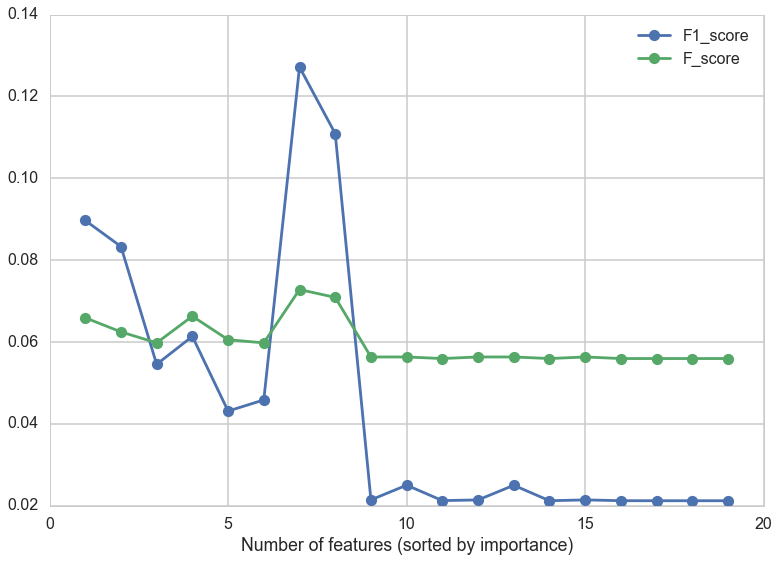

In [35]:
plt.plot(nf, f1_score_, 'bo-', label='F1_score')
plt.plot(nf, f_score_, 'go-', label='F_score')
plt.xlabel('Number of features (sorted by importance)')
plt.legend(loc='best')
plt.show()

In [40]:
RFC = RandomForestClassifier(n_estimators=1000, criterion='gini',
                           max_features='sqrt', max_depth=10, n_jobs=2,
                            min_samples_leaf=1, oob_score=True)
RFC.fit(MACHO_x_HiTS_t[sorted_FATS_feats_M.FEATURES[:7]], MACHO_x_HiTS_t['label'])
type_pred_M = RFC.predict(HiTS_x_MACHO[sorted_FATS_feats_M.FEATURES[:7]])
y_prob_M = RFC.predict_proba(HiTS_x_MACHO[sorted_FATS_feats_M.FEATURES[:7]])
HiTS_x_MACHO['Var_Type_pred_M'] = type_pred_M
clases = RFC.classes_
score_Mt = RFC.score(HiTS_x_MACHO[sorted_FATS_feats_M.FEATURES[:7]], HiTS_x_MACHO['Var_Type'])
f1_score_Mt = metrics.f1_score(HiTS_x_MACHO['Var_Type'], HiTS_x_MACHO['Var_Type_pred_M'],
                                   average='macro',labels=clases)

print 'Features:', sorted_FATS_feats_M.FEATURES[:7]
print 'Score in HiTS training set: %f' % (score_Mt)
print 'F1-score in test set: %f' % (f1_score_Mt)
print '_____________________'

/Users/jorgetil/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Features: 47                     Psi_eta
46                      Psi_CS
7                        Color
51             SlottedA_length
8                          Con
12    FluxPercentileRatioMid50
49                         Rcs
Name: FEATURES, dtype: object
Score in HiTS training set: 0.070115
F1-score in test set: 0.114194
_____________________


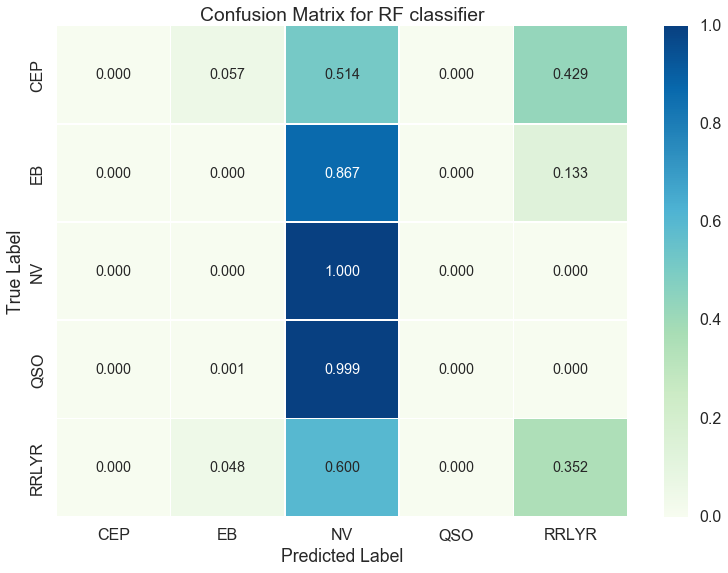

In [41]:
conf_matrix(np.array(HiTS_x_MACHO['Var_Type']), np.array(HiTS_x_MACHO['Var_Type_pred_M']), clases)

['CEP' 'EB' 'NV' 'QSO' 'RRLYR']


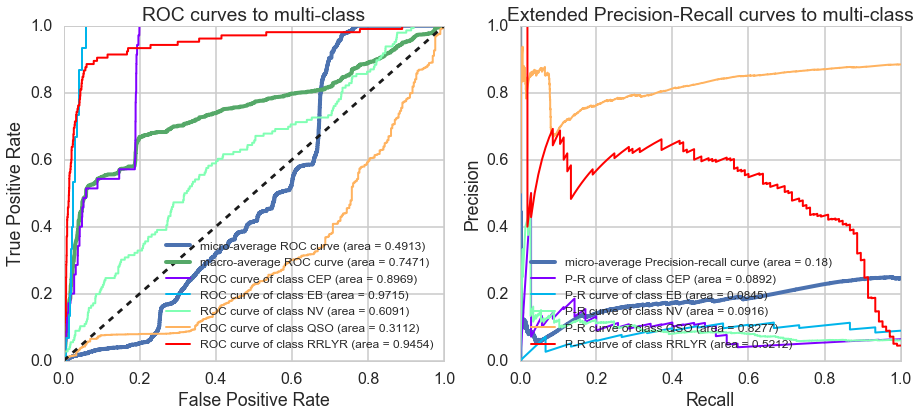

In [42]:
print clases
PR_ROC_curves(HiTS_x_MACHO.Var_Type, y_prob_M, clases)

# Transfer Learning from MACHO using all classes present in MACHO

In [44]:
# Random Forest in MACHO'
RFC.fit(MACHO_t[sorted_FATS_feats_M.FEATURES[:7]], MACHO_t['label'])
clases_M = RFC.classes_

In [45]:
target_sample = table_15[table_15.Var_Type.isnull()]
target_sample = target_sample.query('Median_g>16 and Median_r>16')
print target_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1435750 entries, Blind15A_04_N1_0200_3669 to Blind15A_50_S31_1865_3390
Data columns (total 86 columns):
Unnamed: 0                         1435750 non-null int64
DEC                                1435750 non-null float64
ELLIPTICITY                        1435750 non-null float64
FLAGS                              1435750 non-null int64
FLUX_RADIUS                        1435750 non-null float64
FWHM                               1435750 non-null float64
KRON_RADIUS                        1435750 non-null float64
Median_err_g                       1435750 non-null float64
Median_err_r                       1435750 non-null float64
Median_g                           1435750 non-null float64
Median_r                           1435750 non-null float64
Occu_g                             1435750 non-null int64
Occu_r                             1435750 non-null int64
RA                                 1435750 non-null float64
STD_g              

In [46]:
Pred_Var_Type = []
prob_target = []
chunks = range(0,len(target_sample), 10000)
for kk in range(len(chunks)-1):
    print chunks[kk],':',chunks[kk+1],'|',
    Pred_Var_Type__ = RFC.predict(target_sample.iloc[chunks[kk]:chunks[kk+1]][sorted_FATS_feats_M.FEATURES[:7]])
    prob_target__ = RFC.predict_proba(target_sample.iloc[chunks[kk]:chunks[kk+1]][sorted_FATS_feats_M.FEATURES[:7]])
    Pred_Var_Type.extend(Pred_Var_Type__)
    prob_target.extend(prob_target__)
    #if kk == 10: break
print chunks[kk+1],':',len(target_sample)
Pred_Var_Type__ = RFC.predict(target_sample.iloc[chunks[kk+1]:][sorted_FATS_feats_M.FEATURES[:7]])
prob_target__ = RFC.predict_proba(target_sample.iloc[chunks[kk+1]:][sorted_FATS_feats_M.FEATURES[:7]])
Pred_Var_Type.extend(Pred_Var_Type__)
prob_target.extend(prob_target__)
Pred_Var_Type = np.asarray(Pred_Var_Type)
prob_target = np.asarray(prob_target)

print Pred_Var_Type.shape
print prob_target.shape

0 : 10000 | 10000 : 20000 | 20000 : 30000 | 30000 : 40000 | 40000 : 50000 | 50000 : 60000 | 60000 : 70000 | 70000 : 80000 | 80000 : 90000 | 90000 : 100000 | 100000 : 110000 | 110000 : 120000 | 120000 : 130000 | 130000 : 140000 | 140000 : 150000 | 150000 : 160000 | 160000 : 170000 | 170000 : 180000 | 180000 : 190000 | 190000 : 200000 | 200000 : 210000 | 210000 : 220000 | 220000 : 230000 | 230000 : 240000 | 240000 : 250000 | 250000 : 260000 | 260000 : 270000 | 270000 : 280000 | 280000 : 290000 | 290000 : 300000 | 300000 : 310000 | 310000 : 320000 | 320000 : 330000 | 330000 : 340000 | 340000 : 350000 | 350000 : 360000 | 360000 : 370000 | 370000 : 380000 | 380000 : 390000 | 390000 : 400000 | 400000 : 410000 | 410000 : 420000 | 420000 : 430000 | 430000 : 440000 | 440000 : 450000 | 450000 : 460000 | 460000 : 470000 | 470000 : 480000 | 480000 : 490000 | 490000 : 500000 | 500000 : 510000 | 510000 : 520000 | 520000 : 530000 | 530000 : 540000 | 540000 : 550000 | 550000 : 560000 | 560000 : 570000

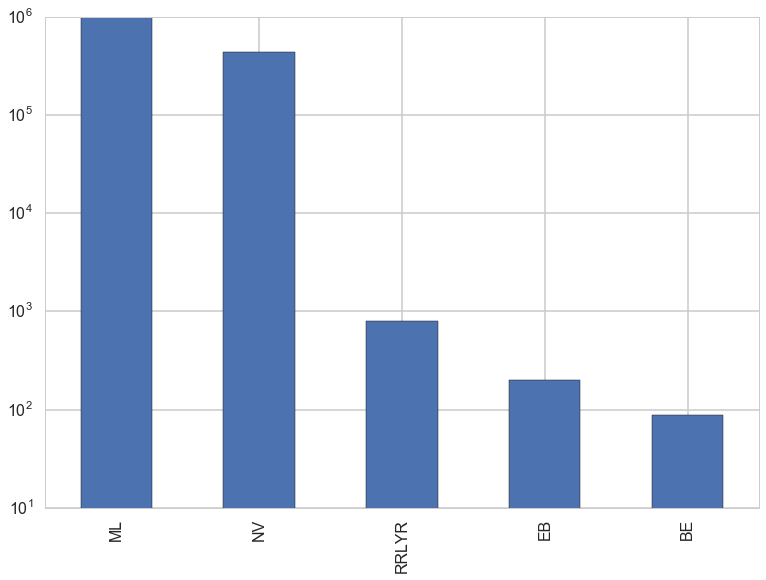

In [47]:
Pred_Var_Type = pd.Series(Pred_Var_Type, index=target_sample.index)
Pred_Var_Type.value_counts().plot(kind="bar")
plt.yscale('log')

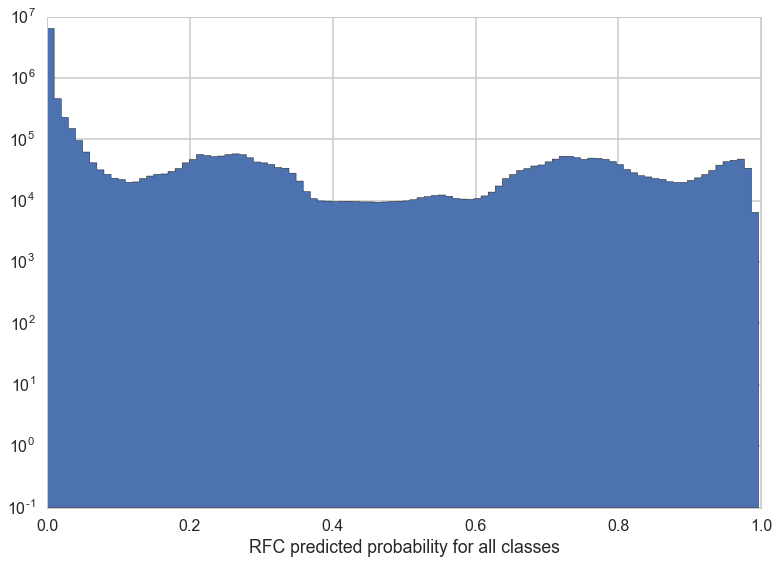

In [48]:
plt.hist(prob_target.ravel(),bins=100,histtype='stepfilled',color='b', log=True)
plt.xlabel('RFC predicted probability for all classes')
plt.show()

In [66]:
Pred_Var_Type.loc['Blind15A_27_N9_0290_2037']

'BE'

In [65]:
prob_target = pd.DataFrame(prob_target, index=target_sample.index, columns=clases_M)
prob_target.loc['Blind15A_27_N9_0290_2037']

BE       0.323677
CEP      0.000143
EB       0.099753
ML       0.213470
NV       0.173839
QSO      0.055422
RRLYR    0.133697
Name: Blind15A_27_N9_0290_2037, dtype: float64

In [105]:
target_sample['Prob_Pred'] = None
target_sample['Pred_Var_Type'] = None
for k,clas in enumerate(prob_target.columns):
    print 'Class: %s\t| ' % (clas),
    print 'Max prob of all entries: ', prob_target[clas].max()
    
    index_best_ten = prob_target[clas].nlargest(n=10).index.values
    mask_best_ten = (prob_target.loc[index_best_ten].idxmax(axis=1) == clas).values
    
    target_sample.loc[index_best_ten[mask_best_ten],'Pred_Var_Type'] = clas
    target_sample.loc[index_best_ten[mask_best_ten],'Prob_Pred'] = prob_target.loc[index_best_ten[mask_best_ten],clas].values
    print target_sample.loc[index_best_ten[mask_best_ten],['Pred_Var_Type','Prob_Pred']]
    print '____________________________'

Class: BE	|  Max prob of all entries:  0.364049912449
                          Pred_Var_Type Prob_Pred
ID                                               
Blind15A_34_N18_1032_2287            BE   0.36405
Blind15A_29_N5_1917_0928             BE  0.341753
Blind15A_27_N6_0794_0156             BE    0.3374
Blind15A_29_S12_0947_3400            BE  0.335893
Blind15A_27_N6_0412_2088             BE  0.333826
Blind15A_31_N10_1791_3635            BE  0.324811
Blind15A_27_N16_0504_1769            BE  0.324796
Blind15A_27_N9_0290_2037             BE  0.323677
Blind15A_25_N31_1032_0598            BE  0.323528
Blind15A_10_N15_1474_0600            BE   0.32124
____________________________
Class: CEP	|  Max prob of all entries:  0.128772866023
Empty DataFrame
Columns: [Pred_Var_Type, Prob_Pred]
Index: []
____________________________
Class: EB	|  Max prob of all entries:  0.799886365009
                          Pred_Var_Type Prob_Pred
ID                                               
Blind15A_19_S9_00

In [106]:
best_pred = target_sample.dropna(subset=['Pred_Var_Type','Prob_Pred'])
best_pred.to_csv('%s/tables/Blind15A_candidates_from_MACHO.csv'
                        % (mainpath))